# Monkey Finger Movement Dataset

## 1. Overview

The following dataset includes data from two recording sessions of a macque performing a two degree-of-freedom (DOF) finger movement task, with neural activity recorded from the hand area of the primary motor cortex. The data presented here, provided by the Chestek Lab at the University of Michigan, is a modified version of data hosted on Deep Blue Data, provided by the University of Michigan Library [here](https://deepblue.lib.umich.edu/data/concern/data_sets/0g354f51t) (also accessible through the Chestek Lab website [here](https://chestekresearch.engin.umich.edu/data-and-resources/)). Specifically, the datasets are taken from Data.zip/MonkeyN_CO.mat and Data.zip/MonkeyN_R.mat. 

The full, unmodified dataset was used to generate many of the results presented in the [Nason, S. R. et al. 2021 study](https://doi.org/10.1016/j.neuron.2021.08.009), "Real-time linear prediction of simultaneous and independent movements of two finger groups using an intracortical brain-machine interface", published in Neuron.

<center><img src="img\methods.png"/></center>

### 1.1 Task

In the finger movement task, a rhesus macaque (Monkey N) performed successive 'trials' where he had to independently move his index finger (IDX) and middle-ring-pinky fingers (MRP) to match target positions within a set time limit. The targets were shown using a monitor placed in front of him, as shown above, which displayed a virtual hand and two spherical targets (red for IDX, yellow for MRP). Once the monkey reached the targets, he had to hold his fingers in place for a set 'hold time' to complete the the trial successfully. After each successful trial, the monkey received a juice reward.

The datasets provided here consist of two different 'target styles', center-out and random targets. In the center-out task, trials alternate between 'rest' trials and 'reach' trials. Rest trials present both targets at halfway between flexion and extension, while reach trials involve some kinda of movement away from rest - split movements in different directions, both fingers flexing/extending, and single group flexion/extension. In the random task, targets are presented pseudo-randomly for both finger groups, although a limit is imposed on how far finger groups can be separated from one another. Datasets from the center-out and random tasks are labelled 'co_feats##.pkl' and 'r_feats##.pkl', respectively.

### 1.2 Data

For these datasets, 96 channels of neural activity were recorded from a Utah array implanted in the hand area of a monkey's motor cortex during the task. The neural feature used in these datasets is Spiking-Band Power (SBP), as described by Nason et al. 2020 in Nature Biomedical engineering ([link](https://doi.org/10.1038/s41551-020-0591-0)).

Additionally, relative finger position along the arc of flexion/extension was measured using a flex sensors in the manipulandum where the monkeys hand was placed. We estimated the finger group velocities and accelerations using the recorded hand positions.

The random and center-out trials provided are each two sets of experiments combined into one (four experiments combined into two total). All trials were collected on the same day, but other tasks were performed in between. In the center-out dataset, trial 752 marks the start of the second block, and in the random dataset, trial 497 marks the start of the second block. In both datasets, some trials are excluded, likely due to trial failure.\

Neural data was originally recorded at 2ksps, and behavior was recorded at 1ksps. However, decoding is typically done on larger time bins. The datasets provided all contain the same data binned at different sizes, 10ms, 20ms, 32ms, 50ms, and 100ms, indicated by the number in the filename. For example, 'r_feats32.pkl' contains the random task data binned at 32ms, and 'r_feats50.pkl' contains the same data binned at 50ms.

## 2. Exploring the data

### 2.1 Setup

First, let's load one of the datasets and import things we may need. For this example, we will used the 32ms center-out dataset.

In [65]:
# imports
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib notebook
from ipywidgets import *

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [2]:
# load dataset using pickle - assuming you are opening this in the github?
datapath = os.path.join(os.getcwd(),os.pardir,'Datasets\\co_feats32.pkl')
with open(datapath, 'rb') as f:
    data = pickle.load(f)

### 2.2 Data Structure

Each .pkl file contains a dictionary of 5 length N numpy.ndarrays, where N is the total number of time bins in the dataset. The keys and their contents are listed below:

* `'neural'` - Nx96 numpy.ndarray containing the binned (average) SBP for all 96 channels.
* `'behavior'` - Nx6 ndarray containing finger kinematics in the following order: `[IDX_position, MRP_position, IDX_velocity, MRP_velocity, IDX_accel, MRP_accel]`
* `'trialNumber'` - Nx1 ndarray containing the current trial number.
* `'targetPosition'` - Nx2 ndarray containing the target position for both finger groups (`[IDX_target, MRP_target]`).
* `'targetWidth'` - Nx1 ndarray containing the target width.

In [8]:
# quick lil dataframe to make it visual
dfs = []
for key in data.keys():
    dfs.append(pd.DataFrame(data[key]))
dfs = pd.concat(dfs, axis=1, keys=data.keys())
dfs

neural                                                       \
               0          1          2          3         4         5   
0       9.156250   9.265625  11.515625  10.671875  6.500000  6.968750   
1       8.876923   9.169231  13.153846   8.661538  5.707692  7.338462   
2      10.609375  11.593750  10.453125  11.937500  6.640625  7.281250   
3       9.937500   8.750000  10.250000  11.468750  6.046875  5.515625   
4      10.687500   9.390625  13.296875  12.171875  7.031250  6.343750   
...          ...        ...        ...        ...       ...       ...   
58922  13.765625  13.859375  16.625000  15.125000  7.015625  7.312500   
58923  14.218750  10.468750  18.312500  12.953125  7.609375  7.140625   
58924  16.015625  10.765625  19.640625  13.421875  6.843750  7.593750   
58925  12.184615  10.753846  15.507692  12.230769  6.600000  7.246154   
58926  13.578125  11.875000  17.921875  11.203125  7.093750  7.078125   

                                                   ...  behavior            \
               6          7          8          9  ...         0         1   
0      10.078125   8.453125   8.062500   8.109375  ...  0.538462  0.590020   
1      16.492308   9.384615   8.200000   7.061538  ...  0.538341  0.590323   
2      13.921875   7.640625   8.062500   6.890625  ...  0.537981  0.590323   
3      11.406250   8.218750   8.937500   8.375000  ...  0.537981  0.589919   
4      13.000000   8.953125   8.375000   8.218750  ...  0.538822  0.590423   
...          ...        ...        ...        ...  ...       ...       ...   
58922  17.984375   9.281250  10.906250   9.421875  ...  0.593149  0.639214   
58923  15.046875  11.875000  12.156250   7.875000  ...  0.578245  0.662802   
58924  12.625000  11.906250  10.265625   9.515625  ...  0.546034  0.734375   
58925  17.076923  10.030769   9.646154  10.061538  ...  0.550601  0.759980   
58926  11.718750   8.750000  10.828125   9.609375  ...  0.547716  0.753730   

                                              trialNumber targetPosition       \
              2         3         4         5           0              0    1   
0     -0.000120  0.000302 -0.000240 -0.000302           1            0.5  0.5   
1     -0.000361  0.000000  0.000361 -0.000403           1            0.5  0.5   
2      0.000000 -0.000403  0.000841  0.000907           1            0.5  0.5   
3      0.000841  0.000504 -0.001442 -0.000504           1            0.5  0.5   
4     -0.000601  0.000000  0.001442  0.000202           1            0.5  0.5   
...         ...       ...       ...       ...         ...            ...  ...   
58922 -0.014904  0.023589 -0.017308  0.047984        1530            0.5  0.8   
58923 -0.032212  0.071573  0.036779 -0.045968        1530            0.5  0.8   
58924  0.004567  0.025605 -0.007452 -0.031854        1530            0.5  0.8   
58925 -0.002885 -0.006250  0.000000  0.000000        1530            0.5  0.8   
58926  0.000000  0.000000  0.000000  0.000000        1530            0.5  0.8   

      targetWidth  
                0  
0           0.075  
1           0.075  
2           0.075  
3           0.075  
4           0.075  
...           ...  
58922       0.075  
58923       0.075  
58924       0.075  
58925       0.075  
58926       0.075  

[58927 rows x 106 columns]

### 2.3 Visualizing movements

We can visualize movements by plotting the trajectory of each finger over time. Additionally, we can add the targets as rectangles to see when the monkey actually reaches the targets for each finger. Feel free to take and adapt this function as you please!

<IPython.core.display.Javascript object>


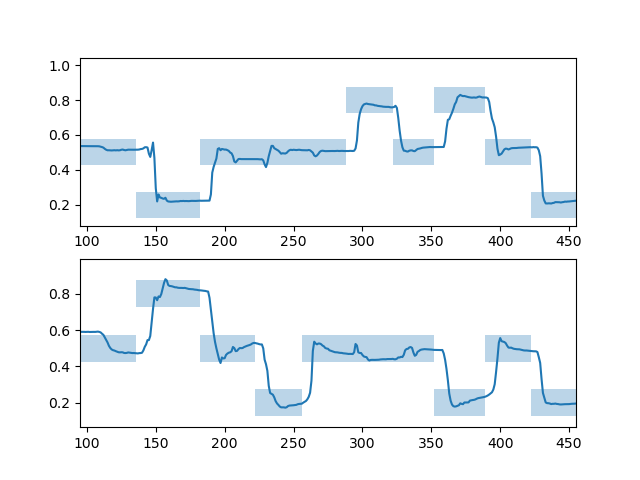

In [57]:
import pdb
def plottrials(data, finger, starttrial, numtrials, ax):
    # get list of trials, first index of each, and length of each
    trials, tidx, tlens = np.unique(data['trialNumber'], return_index=True, return_counts=True)
    
    startidx = int(np.argwhere(trials == starttrial)[0])
    startbin = tidx[startidx]
    endbin = tidx[startidx+numtrials]
    #get target location and width for each trial
    targets = data['targetPosition'][tidx,:]
    twidths = data['targetWidth'][tidx,:]

    for i in np.arange(startidx,startidx+numtrials):
        rect = mpl.patches.Rectangle((tidx[i], targets[i,finger] - twidths[i,0]),tlens[i], twidths[i,0]*2, alpha=0.3)
        ax.add_patch(rect)
    
    ax.plot(data['behavior'][:,finger])
    startidx = int(np.argwhere(trials == starttrial)[0])
    ax.set(xlim=(startbin, endbin))
    
fig, ax = plt.subplots(2,1)

plottrials(data, 0, 2, 10, ax[0])
plottrials(data, 1, 2, 10, ax[1])

#todo - add velocities and acceleration examples to plots?

The top plot shows the index position and targets for the first 10 trials, and the bottom shows the same for MRP.

### 2.4 Single-neuron responses

Something we might be interested in looking at is how individual neurons respond to specific movements. This is relatively simple to look at when using a center-out task, where the same movements are repeated over and over. Below, we group all movements of the same type and look at how individual neurons respond.

<IPython.core.display.Javascript object>


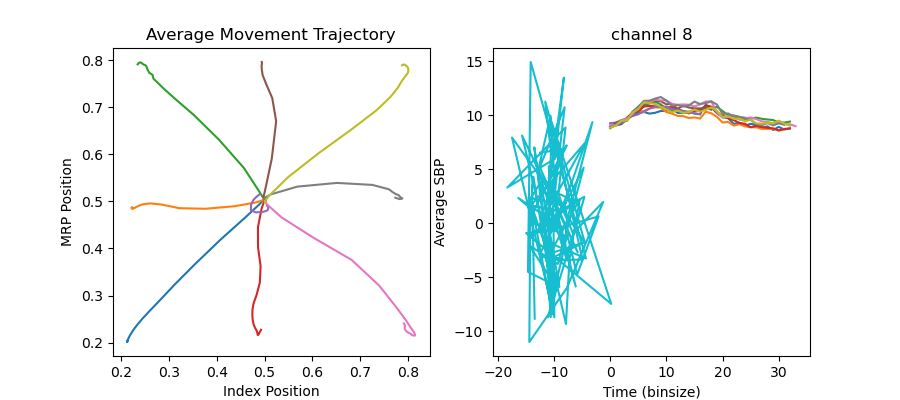

interactive(children=(IntSlider(value=0, description='Channel', max=95), Output()), _dom_classes=('widget-inte…

<function __main__.update(Channel=0)>

In [64]:
#todo - group center out movements and show average velocity, as well as corresponding neural data?
reachpositions = np.unique(data['targetPosition'], axis=0)

fig, ax = plt.subplots(1,2, figsize=(9,4))
lines = []

grouped = {'neural':[], 'behavior':[]}
for position in reachpositions:
    #get all trials for this target positions
    trials = np.unique(data['trialNumber'][np.argwhere((data['targetPosition'] == position).all(axis=1))])

    lens = np.stack([np.sum(data['trialNumber'] == trial) for trial in trials])
    
    # we need to align our trials since they are usually different lengths. 
    # There are better ways to do this (time warping, etc.), but here we'll just truncate to the shortest trial of the group
    behavior = np.zeros((len(lens), np.min(lens), 6))
    neural = np.zeros((len(lens), np.min(lens), 96))
    for i, trial in enumerate(trials):
        behavior[i,:,:] = data['behavior'][(data['trialNumber'] == trial)[:,0],:][0:np.min(lens),:]
        neural[i,:,:] = data['neural'][(data['trialNumber'] == trial)[:,0],:][0:np.min(lens),:]
    
    grouped['behavior'].append(behavior)
    grouped['neural'].append(neural)
    
    mean_behavior = np.mean(behavior, axis=0)
    mean_neural = np.mean(neural, axis=0)
    
    ax[0].plot(mean_behavior[:,0],mean_behavior[:,1],label=position)
    line, = ax[1].plot(mean_neural[:,0])
    lines.append(line)

ax[0].set(title='Average Movement Trajectory',xlabel='Index Position',ylabel='MRP Position')
ax[1].set(ylabel='Average SBP',xlabel='Time (binsize)')

# this allows us to interactively change the second plot to display different channels.
def update(Channel = 0):
    for i,position in enumerate(reachpositions):
        mean_neural = np.mean(grouped_neural[i], axis=0)
        lines[i].set_ydata(mean_neural[:,Channel])
    ax[1].relim()
    ax[1].autoscale_view()
    ax[1].set(title=f'channel {Channel}')
    fig.canvas.draw_idle()
        
interact(update, Channel = (0,95,1))

In the above plots: On the left, you can see the average trajectory for each movement type. In the right plot, you can see the average response by movement type for a single neuron. Using the slider below the plots, you can change which channel is shown on the plot. Poke around and see if you can spot any noticeable changes in response!

### 2.5 Decoding Finger Kinematics

Next, we'll try to decode the monkey's finger velocities using the neural data. We'll use a ridge regression, an regularized version of linear regression. Additionally, we'll add some time history, basically appending columns to the neural data with the data shifted, to give the decoder the ability to look back. Since there's typically some lag between when movements are represented in the brain and when they're actually performed, this should improve our decode.

In [52]:
# get neural data and hand velocities
neu = data['neural']
vel = data['behavior'][:,[2,3]]

# adding time history
hist = 6
adjneu = np.zeros((neu.shape[0]-hist, 96, hist+1))
for h in range(hist+1):
    adjneu[:,:,h] = neu[h:neu.shape[0]-hist+h,:]
adjneu = adjneu.reshape(adjneu.shape[0],-1)
adjvel = vel[hist:,:]

# separate a training and test set
X_train, X_test, y_train, y_test = train_test_split(adjneu, adjvel, test_size=0.2, shuffle=False)

# train a ridge regression
ridge = Ridge(alpha=0.001)
ridge.fit(X_train, y_train)

# add a grid search maybe?

Ridge(alpha=0.001)

Now, our model is trained, and we can test it:

In [53]:
# test the ridge regression
yhat = ridge.predict(X_test)

# show test r^2
print(f'Test R2: {ridge.score(X_test, y_test)}')

Test R2: 0.32049903210096853


<IPython.core.display.Javascript object>


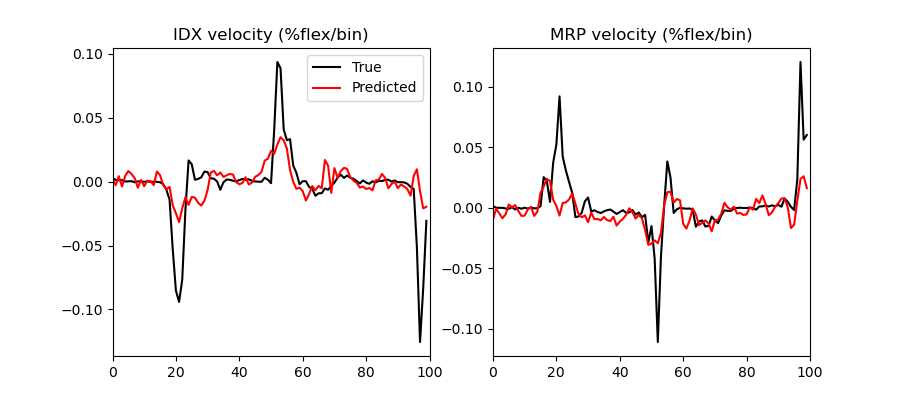

In [62]:
# plot predicted vs. true kinematics

fig, ax = plt.subplots(1,2, figsize = (9, 4))
finger = ['IDX','MRP']
for i in range(2):
    ax[i].plot(y_test[0:100,i], c='k')
    ax[i].plot(yhat[0:100,i], c='r')
    ax[i].set(xlim=(0,100),title=f'{finger[i]} velocity (%flex/bin)')
    if i == 0:
        ax[i].legend(('True', 'Predicted'))

### 2.6 Neural Trajectories

Instead of single-neuron responses, we could have a look at how the neural activity changes with different movements at a population level. To do this, we can use a dimensionality reduction technique like principal component analysis (PCA) to see how our the activity changes at a higher level in a 'latent space'. 

For those unfamiliar, PCA calculates new axes for a dataset which, in order, account for the largest variance in the data overall. In our case, this means PCA gives us a transform which shifts our data from a space where each dimension represents a neural channel to a space where each dimension accounts for a progressively smaller amount of the variance in neural data. These new dimensions are called the principal components (PCs), and can be used to i) look at how a high-dimensional dataset changes at a population level, and ii) as a dimensionality reduction tool, where you apply PCA to a large dataset and then only take only the top few PCs which account for most of the variance.

<IPython.core.display.Javascript object>


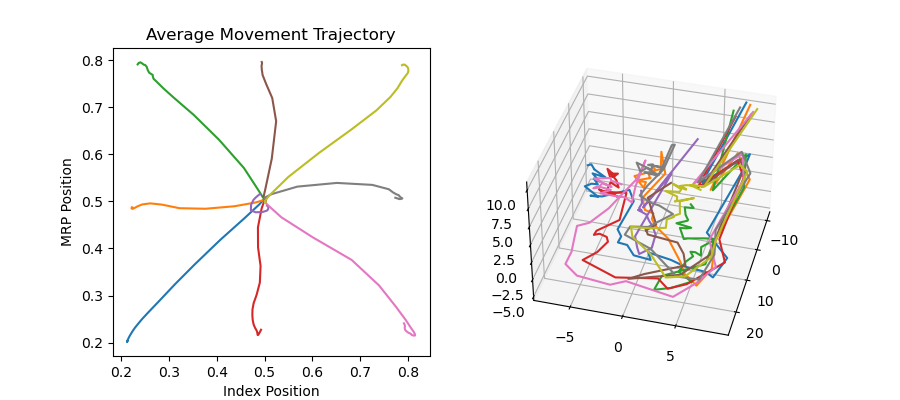

[0.24812291 0.10394717 0.08925182]


C:\Users\Hisham\AppData\Local\Temp\ipykernel_10004\686290127.py:39: UserWarning: Matplotlib is currently using nbAgg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [89]:
# run pca on our neural data
pca = PCA()
neural_pca = pca.fit_transform(data['neural'])

#lets group these by positions and average, like before:
reachpositions = np.unique(data['targetPosition'], axis=0)

fig = plt.figure(figsize=(9,4))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2, projection='3d')
ax = [ax1,ax2]

grouped = {'neural_pca':[], 'behavior':[]}
for position in reachpositions:
    #get all trials for this target positions
    trials = np.unique(data['trialNumber'][np.argwhere((data['targetPosition'] == position).all(axis=1))])

    lens = np.stack([np.sum(data['trialNumber'] == trial) for trial in trials])
    
    # we need to align our trials since they are usually different lengths. 
    # There are better ways to do this (time warping, etc.), but here we'll just truncate to the shortest trial of the group
    behavior = np.zeros((len(lens), np.min(lens), 6))
    neural = np.zeros((len(lens), np.min(lens), 96))
    for i, trial in enumerate(trials):
        behavior[i,:,:] = data['behavior'][(data['trialNumber'] == trial)[:,0],:][0:np.min(lens),:]
        neural[i,:,:] = neural_pca[(data['trialNumber'] == trial)[:,0],:][0:np.min(lens),:]
    
    grouped['behavior'].append(behavior)
    grouped['neural_pca'].append(neural)
    
    mean_behavior = np.mean(behavior, axis=0)
    mean_neural = np.mean(neural, axis=0)
    
    ax[0].plot(mean_behavior[:,0],mean_behavior[:,1],label=position)
    ax[1].plot(mean_neural[:,0], mean_neural[:,1],mean_neural[:,2])
    
ax[0].set(title='Average Movement Trajectory',xlabel='Index Position',ylabel='MRP Position')
plt.show()
print(pca.explained_variance_ratio_[0:3])

Similarly to Section 2.4, the plot on the left shows the average trajectory for each kind of movement in the center-out task. On the right, we can see a 3-D plot (which you can rotate by clicking and dragging) showing the average trajectory of the first 3 principal components for each movement. 

By selecting the first few PC's, we can look at how the neural data changes as a population over time, rather than looking at each channel individually. As you examine these 'neural trajectories' note the similarities, the rotation-like movement through the lower-dimensional subspace of these first the principal components, but also, note the differences. 

Below the plots, we've printed the variance in the data explained by each of the top 3 principal components. Combined, they account for less than 50% of the variance in our neural data, so there is likely still valuable information about the neural population (and potentially about the task) not shown here.

### Summary

In this notebook, we:
- introduced the Monkey finger movement dataset, describing the taks and provided data
- looked at how the data is setup
- demonstrated the task by plotting example movements
- explored single-neuron responses by plotting average SBP for center-out movements
- evaluated how SBP population activity can decode finger velocities
- visualized the timecourse of the neural population activity by extracting trial-averaged neural trajectories with PCA